
# Rate laws for reversible reactions



-   We can think of reversible reactions as two reactions going in opposite directions.

-   $A + B \rightleftharpoons C + D$ can be thought of as:

-   $A + B \rightarrow C + D$
-   $C + D \rightarrow A + B$

-   Each reaction has a forward reaction rate, e.g.:

\begin{align}
r_1 = k_1 C_A C_B \\
r_2 = k_2 C_C C_D
\end{align}

-   Now, to find the rate that species A is "generated" we have:

$r_{1A} = -r_1$ and $r_{2A} = r_2$, and the net rate is $r_A = r_{1A} + r_{2A} = -k_1 C_A C_B + k_2 C_C C_D$.

-   At equilibrium, the net rate must be zero, which means:

\begin{align}
k_1 C_{A,eq} C_{B,eq} = k_2 C_{C,eq} C_{D,eq}
\end{align}

or:

\begin{align}
\frac{k_1}{k_2} = \frac{C_{C,eq} C_{D,eq}}{C_{A,eq} C_{B,eq}} = K_{eq}
\end{align}

-   You can see that between $k_1$, $k_2$ and $K_{eq}$, only two of them are independent. i.e. $k_2 = k_1 / K_{eq}$.

-   Thus, we may also see net reaction rates for equilibrium reaction rates written as:

\begin{align}
r_A = k_1(C_A C_B - \frac{C_C C_D}{K_{eq}})
\end{align}

-   It is important that these constraints exist, so that thermodynamics are not violated.




## A CSTR with a reversible reaction



-   Recall the water gas shift reaction we discussed before $H_2O + CO \rightleftharpoons CO_2 + H_2 $.

-   We previously calculated the equilibrium coefficient to be 1.44 at 1000K.
-   Assume the reaction is elementary, and the forward rate constant is $k_1 = 0.02$ L / (mol \* s)

-   The reactor is initially fed pure A and B at concentrations of 0.05 mol / L.

-   What is the exit concentration of A? the reactor volume is 10 L, and the volumetric flow rate into the reactor is 0.01 L / s.



In [17]:
from scipy.optimize import fsolve

Keq = 1.44395809814
v0 = 0.01 # L / s
V = 10    # L

k1 = 0.02 # L / mol / s

Ca0 = Cb0 = 0.05 # mol / L
Cc0 = Cd0 = 0.0

Fa0 = v0 * Ca0

def cstr(Ca):
    xi = (Ca - Ca0) / (-1) # compute reaction extent
    Cb = Cb0 - xi
    Cc = Cc0 + xi
    Cd = Cd0 + xi

    ra = -k1 * (Ca * Cb - (Cc * Cd) / Keq)
    return Fa0 - Ca * v0 + V * ra

guess = 0.002
ca_exit, = fsolve(cstr, guess)

print('the exit concentration of C_A is {0:1.4f} mol / L'.format(ca_exit))
print('the exit concentration of C_C is {0:1.4f} mol / L'.format(Ca0 - ca_exit))


print('(C_C C_D)/(C_A C_B)=%f'%(((Ca0 - ca_exit)/ca_exit)**2.))


#import matplotlib.pyplot as plt 
#import numpy as np 
#x = np.linspace(-10, 0.2)
#c = [cstr(x1) for x1 in x] 
#plt.plot(x, c)
#plt.show()

the exit concentration of C_A is 0.0327 mol / L
the exit concentration of C_C is 0.0173 mol / L
(C_C C_D)/(C_A C_B)=0.278840


-   There is less C produced than you would expect from the equilibrium composition
-   The reactants are not in the reactor long enough to reach equilibrium

-   You can explore this solution. Try using a lower volumetric flow rate, or a larger volume reactor. You will see that the concentrations converge to the equilibrium limit we computed before



In [2]:
from scipy.optimize import fsolve

Keq = 1.44395809814
v0 = 0.01 # L / s
V = 10    # L

k1 = 0.02 # L / mol / s

Ca0 = Cb0 = 0.05 # mol / L
Cc0 = Cd0 = 0.0

Fa0 = v0 * Ca0
Fb0 = v0 * Cb0
Fc0 = v0 * Cc0
Fd0 = v0 * Cd0

def cstr(C):
    Ca, Cb, Cc, Cd = C    
    ra = -k1 * (Ca * Cb - (Cc * Cd) / Keq)
    rb = ra
    rc = -ra
    rd = -ra
    
    return [Fa0 - Ca * v0 + V * ra,
            Fb0 - Cb * v0 + V * rb,
            Fc0 - Cc * v0 + V * rc,
            Fd0 - Cd * v0 + V * rd]

guess = [0.02, 0.02, 0.03, 0.03]
C = fsolve(cstr, guess)

print(C)

[ 0.03272139  0.03272139  0.01727861  0.01727861]



# Mole balances with multiple reactions



-   There is nothing particularly new in mole balances with multiple reactions

-   We still write species based mole balances

-   We use the net rate law for each species

-   This typically leads to coupled equations
    -   For CSTRs these are often coupled nonlinear algebra equations
    -   For PFRs these are often coupled differential equations




## Multiple reactions in a CSTR



-   We consider a reactor design with multiple reactions
-   Mesitylene (trimethyl benzene) can be hydrogenated to form m-xylene, which can be further hydrogenated to toluene

-   The reactions we consider are:

\begin{align}
M + H_2 \rightarrow X + CH_4 \\
X + H_2 \rightarrow T + CH_4
\end{align}

-   The reaction is carried out isothermally at 1500 $^\circ$ R at 35 atm.
-   The feed is 2/3 hydrogen and 1/3 mesitylene
-   The volumetric feed rate is 476 cubic feet per hour and the reactor volume is 238 cubic feet
-   The rate laws are

\begin{align}
r_1 = k_1 C_M C_H^{0.5} \\
r_2 = k_2 C_X C_H^{0.5}
\end{align}

-   The rate constants are:

\begin{align}
k_1 = 55.20 \textrm{(ft$^3$/lb mol)$^{0.5}$/h} \\
k_2 = 30.20 \textrm{(ft$^3$/lb mol)$^{0.5}$/h} \\
\end{align}

Here is the code we need to setup and solve this problem.



In [19]:
def funcC(C):
    vo = 476.0    # ft^3 / hr
    V = 238.0     # ft^3
    Po = 35.0     # atm
    T = 1500.0    # Rankine
    R = 0.73      # in appropriate units
    CTo = Po / R / T

    Cmo = CTo / 3.0
    Cho = CTo * 2.0 / 3.0
    Cxo = 0.0
    Cmeo = 0.0
    Ctolo = 0.0

    tau = V / vo

    CM, CH, CX, CMe, CT = C

    # rate laws
    k1 = 55.20  # (ft^3/lbmol)^0.5/h
    k2 = 30.20  # (ft^3/lbmol)^0.5/h
    r1m = -k1 * CM * CH**0.5
    r2t = k2 * CX * CH**0.5

    # net rates
    rM = r1m
    rH = r1m - r2t
    rX = -r1m - r2t
    rMe = -r1m + r2t
    rT = r2t
    # 0 = Fa0 - Fa + ra * V
    # Fa - Fa0 - ra * V = 0
    # v0 * Ca - v0 * Ca0 - ra * V = 0
    # Ca - Ca0 - ra * tau = 0 
    return [tau * (-rM) - Cmo + CM,
            tau * (-rH) - Cho + CH,
            tau * (-rX) - Cxo + CX,
            tau * (-rMe) - Cmeo + CMe,
            tau * (-rT) - Ctolo + CT]

initGuesses = [0.002, 0.002, 0.002, 0.002, 0.002]
from scipy.optimize import fsolve

exitC = fsolve(funcC, initGuesses)

species = ['M', 'H', 'X', 'Me', 'T']
for s,C in zip(species, exitC):
    print('{0:^3s}{1:1.5f} lbmol/ft^3'.format(s,C))

 M 0.00294 lbmol/ft^3
 H 0.00905 lbmol/ft^3
 X 0.00317 lbmol/ft^3
Me 0.01226 lbmol/ft^3
 T 0.00455 lbmol/ft^3



## Multiple reactions in a PFR



Now we solve the same problem in a PFR.



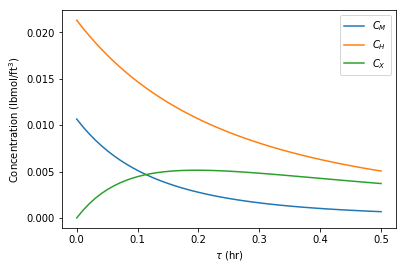

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [46]:
import numpy as np
from scipy.integrate import odeint

vo = 476.0    # ft^3 / hr
Po = 35.0     # atm
T = 1500.0    # Rankine
R = 0.73      # in appropriate units
CTo = Po / R / T
Fto = CTo * vo

# initial molar flows
Fmo = Fto / 3.0
Fho = Fto * 2.0 / 3.0
Fxo = 0.0
Fmeo = 0.0
Ftolo = 0.0


def dFdV(F, t):
    'PFR moe balances'
    Ft = F.sum()

    v = vo * Ft / Fto
    C = F / v
    CM, CH, CX, CMe, CT = C

    # rate laws
    k1 = 55.20
    k2 = 30.20
    r1m = -k1 * CM * CH**0.5
    r2t = k2 * CX * CH**0.5

    # net rates
    rM = r1m
    rH = r1m - r2t
    rX = -r1m - r2t
    rMe = -r1m + r2t
    rT = r2t

    dFMdV = rM
    dFHdV = rH
    dFXdV = rX
    dFMedV = rMe
    dFTdV = rT

    return [dFMdV, dFHdV, dFXdV, dFMedV, dFTdV]

Finit = [Fmo, Fho, Fxo, Fmeo, Ftolo]
Vspan = np.linspace(0.0, 238.0)

sol = odeint(dFdV, Finit, Vspan)

Ft = sol.sum(axis=1)  # sum each row
v = vo * Ft / Fto

FM = sol[:, 0]
FH = sol[:, 1]
FX = sol[:, 2]
FMe = sol[:, 3]
FT = sol[:, 4]

tau = Vspan / vo

import matplotlib.pyplot as plt
plt.plot(tau, FM / v, label='$C_M$')
plt.plot(tau, FH / v, label='$C_H$')
plt.plot(tau, FX / v, label='$C_X$')

plt.legend(loc='best')
plt.xlabel('$\\tau$ (hr)')
plt.ylabel('Concentration (lbmol/ft$^3$)')
plt.show()
print(Ft / Fto)


-   You can see that the basic approach is the same as for a single reaction
    -   the code is just *a lot* longer

-   In this example it was not necessary to compute the total molar flow. Inspection shows that it is a constant. Hence, the volumetric flow is also constant since there is no pressure drop and no temperature change.



- stack traces
- writing answers
  - be comfortable writing Latex
  - format numbers with units
  - label plots with x/y-axis legends (if multiple lines)
  - comment code when possible

In [25]:
def f(a):
    print(np.sum('a'))

f(1)

TypeError: cannot perform reduce with flexible type

In [42]:
def f(P):
    raise TypeError

f(1)

a='-1'
try:
    g=f(a)
except TypeError:
    print('fixed!')
    
print(g)


TypeError: 

In [47]:
help(np.sum)

Help on function sum in module numpy.core.fromnumeric:

sum(a, axis=None, dtype=None, out=None, keepdims=<class 'numpy._globals._NoValue'>)
    Sum of array elements over a given axis.
    
    Parameters
    ----------
    a : array_like
        Elements to sum.
    axis : None or int or tuple of ints, optional
        Axis or axes along which a sum is performed.  The default,
        axis=None, will sum all of the elements of the input array.  If
        axis is negative it counts from the last to the first axis.
    
        .. versionadded:: 1.7.0
    
        If axis is a tuple of ints, a sum is performed on all of the axes
        specified in the tuple instead of a single axis or all the axes as
        before.
    dtype : dtype, optional
        The type of the returned array and of the accumulator in which the
        elements are summed.  The dtype of `a` is used by default unless `a`
        has an integer dtype of less precision than the default platform
        integer.  I